<img src=Logo/DIWASA_Logo.png width=150 height=50 aligh="center"/><img src="Logo/DEA_Logo.png" width=150 height=50 align="right"/>

# Summarize rainfall statistics across multiple scales 

* **Products used:** 
[rainfall_chirps_monthly](https://explorer.digitalearth.africa/products/rainfall_chirps_monthly)

## Background

Precipitation is the primary source of freshwater, essential for various human uses. However, accurate measurement of this resource remains a challenge in many remote regions of Africa, where rain gauge station networks are sparse. Fortunately, freely available precipitation estimates have emerged by combining data from ground stations with remotely sensed products. The utilization of these estimates is becoming increasingly common and serves as valuable input for Water Accounting plus (WA+) frameworks. These frameworks provide crucial insights into water availability and use across any geographic area of interest.

## Description

This analysis leverages monthly CHIRPS precipitation data to generate summaries and visualizations across various spatial scales. These scales can include land cover types, elevation ranges, hydrologic units, climatic zones, or administrative units. Users can provide some of the input datasets for summarization and visualization, while others may be available from the Digital Earth Africa (DEA) repository. In this excercise sub-catchments of the Awash River basin and point locaitons of cities/towns are provided. Users can upload their own area of interest and should use similar attribute names as the sample and codes provided in this jupyter notebook. 

In this notebook the following are outlined:

1.	Load shapefiles of Awash River basin sub catchments and known locations (cities/towns). These datasets are not available in DEA. You need to upload it to your Data folder before you proceed. The datasets provided include:
>•	Awash river basin boundary (ETH_AW_Boundary.shp)<br>
>•	Awash river basin sub-catchments boundary (ETH_AW_Subcatchments.shp)<br>
>•	Selected cities/towns in the Awash basin (ETH_AW_Cities.shp)<br>
2.	Load monthly rainfall data and clip it to the boundary of geographic area of interest.
3.	Calculate long term mean monthly rainfall, plot mean monthly rainfall distribution map, and overlay with sub-catchment and basin boundaries on top of the plot.
4.	Extract average monthly rainfall for selected cities/towns and plot bar chart for each city/town.
5.	Compute zonal statistics of long-term mean monthly and annual rainfall for each sub-catchment, update sub-catchment geodata attribute with the result (monthly and annual values), and plot both static and interactive maps using geopandas plot and explore methods respectively.

## Get started
To run this analysis, run all the cells in the notebook, starting with the "Load packages" cell. 

### Load packages

In [1]:
import datacube                   # For loading data from DEA 
import numpy as np                # Package for handling multidimensional (ndarray) arrays
import pandas as pd               # For handling tabular data, spreadsheet like
import geopandas as gpd           # For Vector data handling
import xarray as xr               # For handling labeled ndarrays
import rioxarray as rxr           # Provide geospatial data handling capabilities to xarray 
import matplotlib.pyplot as plt   # Package for plotting

# Provides dashboard for multi-process computation and diagnostics 
from deafrica_tools.dask import create_local_dask_cluster
# For computing zonal statistics
from rasterstats import zonal_stats
# Built on top of matplotlib, it enables making beautiful and complex statistical graphs
import seaborn as sns
# Help manipulate calendar
import calendar

# To silence version warnings
import warnings
warnings.filterwarnings("ignore")
# Plotting style which simulates r-ggplot
plt.style.use('ggplot')  # ggplot formatting

%matplotlib inline

## Set up a Dask cluster

Dask can be used to better manage memory use and conduct the analysis in parallel. 
For an introduction to using Dask with Digital Earth Africa, see the [Dask notebook](../Beginners_guide/08_Parallel_processing_with_dask.ipynb).

>**Note**: We recommend opening the Dask processing window to view the different computations that are being executed; to do this, see the *Dask dashboard in DE Africa* section of the [Dask notebook](../Beginners_guide/08_Parallel_processing_with_dask.ipynb).

To use Dask, set up the local computing cluster using the cell below.

In [2]:
create_local_dask_cluster()

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /user/mulugetat@aim.com/proxy/8787/status,
Dashboard: /user/mulugetat@aim.com/proxy/8787/status,Workers: 1
Total threads: 4,Total memory: 26.21 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:46347,Workers: 1
Dashboard: /user/mulugetat@aim.com/proxy/8787/status,Total threads: 4
Started: Just now,Total memory: 26.21 GiB
Comm: tcp://127.0.0.1:39151,Total threads: 4
Dashboard: /user/mulugetat@aim.com/proxy/37435/status,Memory: 26.21 GiB
Nanny: tcp://127.0.0.1:39923,


### Set analysis parameters
**If running the notebook for the first time**, keep the default settings below.
This will demonstrate how the analysis works and provide meaningful results.

In [3]:
# Set path to shapefile for area of interest
aoi = "Data/ETH_AW_Subcatchments.shp"
# Shapefile for selected point locaitons
point_location = "Data/ETH_AW_Cities.shp"
# Area of interest boundary
aw_bnd = "Data/ETH_AW_Boundary.shp"
# Set year range to carryout statistics.
year_range = ("1982", "2023")

# CHIRPS has a spatial resolution of ~5x5 km
resolution = (-0.05, 0.05)

# size of dask chunks
dask_chunks = dict(longitude=500, latitude=500)

### Connect to the datacube

To gain access to the datasets stored in the DEA data repository, establish a connection with the datacube. The `app` parameter requires a user-defined argument that must be distict and correspond to the name of the notebook.

In [4]:
dc = datacube.Datacube(app='rainfall_statistics')

### Load the Awash basin sub-catchments shapefile

The shapefile has polygons depicting sub-catchments within the Awash basin of Ethiopia, which will be utilized to summarize rainfall based on the selected temporal scale. Initially, the shapefile needs to be uploaded to the user `Data` folder and subsequently accessed using relative path to the notebook's location.

In [5]:
# Load sub-catchment shapefile
awash_subcatchments = gpd.read_file(aoi).drop(['Shape_Area','Shape_Leng'],axis=1)
# Load basin boundary
awash_bnd = gpd.read_file(aw_bnd)
# Visualize the loaded geodata
awash_subcatchments.explore(color='tan',
                            style_kwds=dict(fill=True, 
                                            opacity=0.5,
                                            color='green',
                                            ))                                     

## Load rainfall data

To begin with, let us examine the product details regarding CHIRPS rainfall. Access to the data can be obtained by specifying the name under which it is identified in the DEA datacube. The CHIRPS data is stored in timestamps that are either daily or monthly, and its original resolution is approximately 0.05 degrees, which is equivalent to nearly 5km.

In [6]:
dc.list_products().loc[dc.list_products()['name'].str.contains('chirps')]

,name,description,license,default_crs,default_resolution
name,,,,,
rainfall_chirps_daily,rainfall_chirps_daily,Rainfall Estimates from Rain Gauge and Satelli...,None,None,None
rainfall_chirps_monthly,rainfall_chirps_monthly,Rainfall Estimates from Rain Gauge and Satelli...,None,None,None


You can observe from the options provided that the search yielded two results: one for daily precipitation and another for monthly precipitation. Our focus is on utilizing the monthly data to calculate yearly, or long-term average monthly and annual values for the Awash basin.

### Create parameters and load data

Using the analysis parameters defined above, load CHIRPS daily rainfall data for the year range specified. Note also the use of input shapefile extent to limit the loding of daily rainfall data for geographic area of interest.  

In [7]:
# Create query parameters
query = {'longitude': (awash_subcatchments.total_bounds[0],  # Minimum x-coordinate - longitude
                       awash_subcatchments.total_bounds[2]), # Maximum x-coordinate - longitude
         'latitude': (awash_subcatchments.total_bounds[1],  # Minimum y-coordinate - latitude
                      awash_subcatchments.total_bounds[3]), # Maximum y-coordinate - Latitude
         'time': year_range,
         'output_crs': 'epsg:4326',
         'resolution': resolution,
         'measurements': ['rainfall'],
         'dask_chunks':dask_chunks
        }
# Load rainfall data
ds = dc.load(product='rainfall_chirps_monthly', **query)

In [8]:
ds

<xarray.Dataset>
Dimensions:      (time: 502, latitude: 87, longitude: 107)
Coordinates:
  * time         (time) datetime64[ns] 1982-01-16T11:59:59.500000 ... 2023-11...
  * latitude     (latitude) float64 12.22 12.17 12.12 ... 8.025 7.975 7.925
  * longitude    (longitude) float64 37.98 38.02 38.08 ... 43.18 43.23 43.28
    spatial_ref  int32 4326
Data variables:
    rainfall     (time, latitude, longitude) float32 dask.array<chunksize=(1, 87, 107), meta=np.ndarray>
Attributes:
    crs:           EPSG:4326
    grid_mapping:  spatial_ref

### Mask no data values
CHIRPS no data values are filled with -9999. To exclude the no data values from further analysis, replace them with numpy's not a number value, np.nan (NaN). 

In [9]:
# Mask no data values and display data
ds = ds.where(ds !=-9999)

## Compute long-term mean monthly values and extract values for the sub-catchments

The target is to extract mean rainfall values for each catchment from long-term mean monthly rainfall. To get the desired output follow the following steps:

1. Compute long-term mean montly values.
2. Visualize the result at basin scale using maps and charts.
3. Extract mean rainfall values over the catchment by applying zonal statistics.
4. Save the result as CSV file format and download to your pc.

### Compute mean monthly rainfall
The groupby method is utilized to initially categorize the monthly values into groups and subsequently calculate the mean. It is important to note that the time dimension and time coordinate names are automatically adjusted to "month" in order to accurately represent the timestamp.

In [10]:
# Compute long-term mean monthly rainfall
ds_monthly = ds.groupby('time.month').mean('time')
# Clip to basin boundary
ds_monthly = ds_monthly.rio.clip(awash_bnd.geometry)
# Mask nodata values
ds_monthly = ds_monthly.where(ds_monthly!=-9999).compute()
# set ds to None to free memofy usage
ds = None

### Map the resulting mean monthly values
Create a visualization of the average monthly rainfall data, incorporating the sub-catchments and basin boundary of the rainfall grid to examine the distribution of rainfall across the basin and sub-catchments. Make necessary adjustments to the "levels" argument values to customize the rainfall classification ranges.

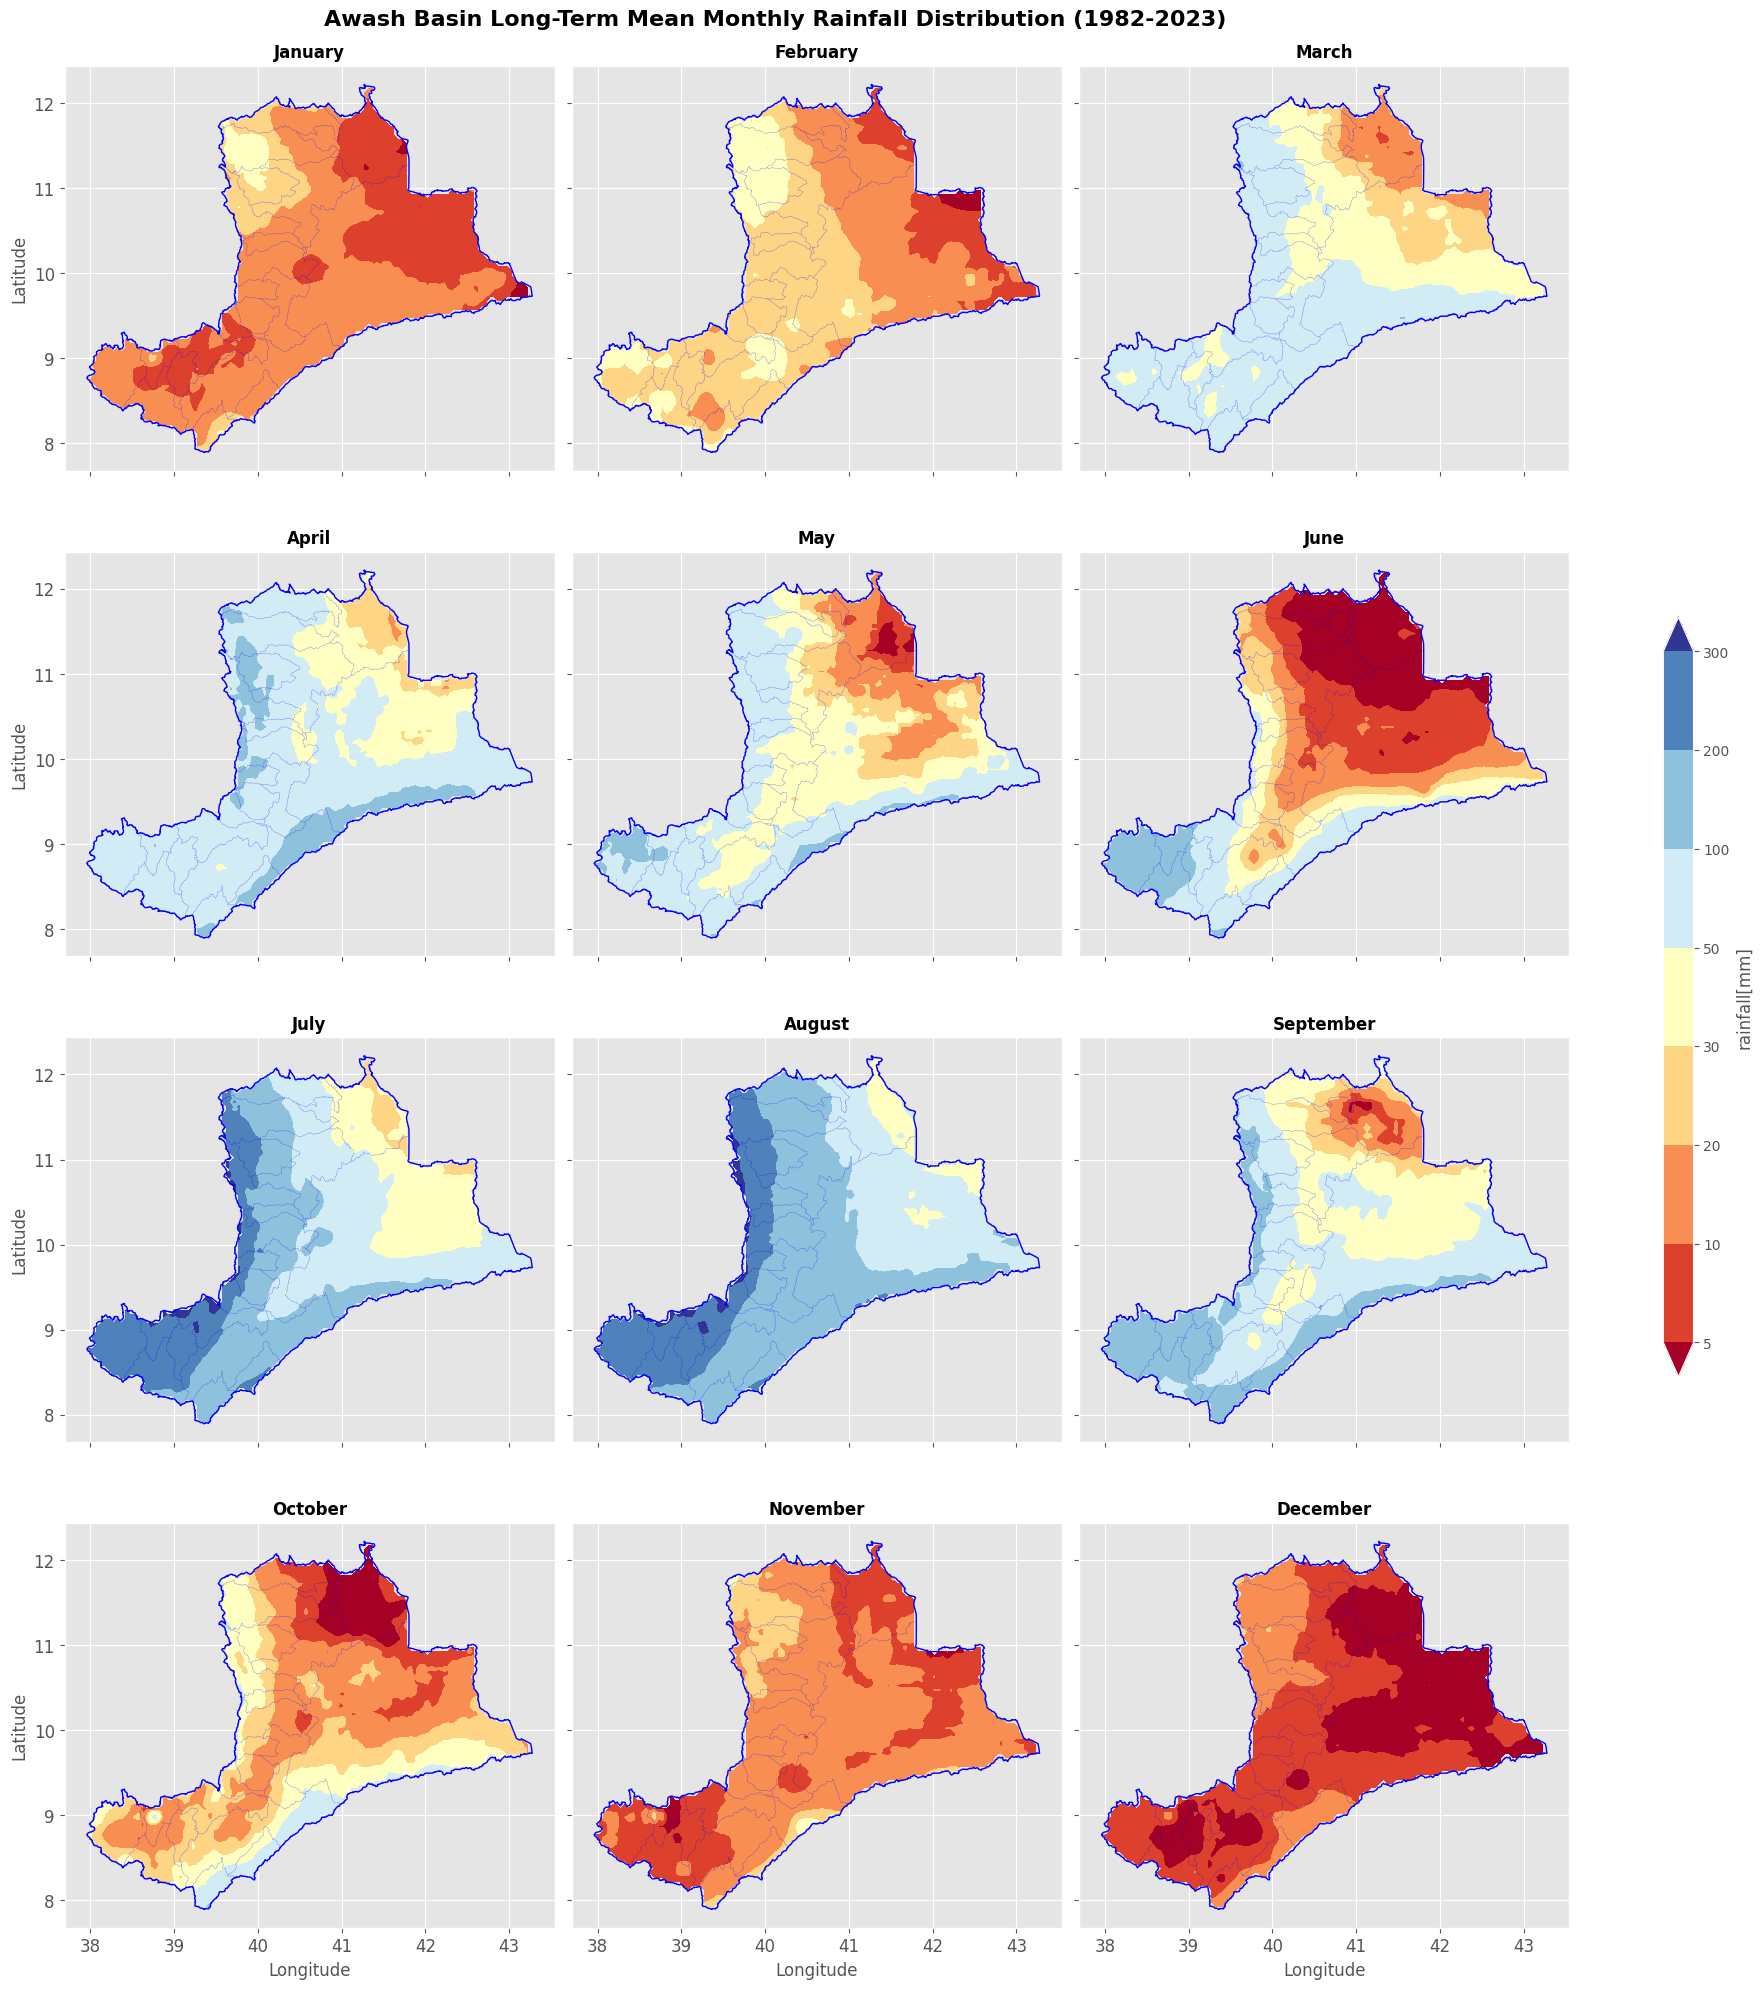

In [11]:
# Create plot object
g = ds_monthly.rainfall.plot.contourf(size=5,
                             aspect=1.25,
                             col='month',
                             col_wrap=3,
                             sharex=True,
                             cmap='RdYlBu',
                             levels=[5,10,20,30,50,100,200,300],
                             add_colorbar=True,
                             cbar_kwargs={'label': 'rainfall[mm]',
                                          'location': 'right',
                                          'shrink':0.4,
                                          'aspect': 25})
# Enumerate and iterate through subplots and set title of each
# subplot using month name
for i, ax in enumerate(g.axs.flat):
    i = i + 1
    # Get month name using calendar module
    title = calendar.month_name[i]
    ax.set_title(title, fontdict={
        'fontsize':12,
        'fontfamily':'sans-serif',
        'fontweight':'bold'
    })

    # Set tick label font size
    ax.tick_params(axis='both', which='major', labelsize=12)
    # Add Awash basin boundary to the plot
    awash_subcatchments.geometry.boundary.plot(color=None,ax=ax,edgecolor='b',linewidth=0.1,linestyle='--')
    # Add sub-catchment boundary
    awash_bnd.geometry.boundary.plot(color=None,ax=ax,edgecolor='b',linewidth=1,linestyle='-')    

# Add x and y axis title and set font size
g.set_xlabels('Longitude', size=12)
g.set_ylabels('Latitude',size=12)
# Add main title to the plot
plt.suptitle(t='Awash Basin Long-Term Mean Monthly Rainfall Distribution (1982-2023)',x=0.4,y=1.0,size=16,weight='bold')
plt.savefig('AW_Montly_rainfall.png')
plt.show()

### Plot rainfall charts for some cities in the basin

This visualization presents the average monthly rainfall patterns for six key cities/towns within the basin: Addis Ababa, Adama, Dessie, Dire Dawa, Gewane, and Semera. It uses bar charts to represent the long-term average rainfall for each month. The coordinate location of the selected cities/towns are presented below
* Addis Ababa: (9.00, 38.75)
* Adama: (8.54, 39.27)
* Dessie: (11.14, 39.64)
* Dire Dawa: (9.60, 41.85)
* Gewane: (10.167, 40.646)
* Semera: (11.79, 41.01)


Bar charts are chosen for this visualization. Each city will have its own bar chart, allowing for a clear comparison of the average monthly rainfall patterns across different locations.

If point shapefile is provided that contains City of point locations in the attribute table,  the code below create dictionary of name key and coordinate values
```
pnt_gdf = gpd.read_file(point_location)
cities = {row['City']: (row['geometry'].x.round(5), row['geometry'].y.round(5)) for i, row in pnt_gdf.iterrows()}
```

In [12]:
# Create dictionary of cities along with their representative
# point coordinates in latitude and longitude
cities = {'Addis Ababa':(9.00,38.75),
          'Adama': (8.54, 39.27),
          'Dessie': (11.14, 39.64),
          'Dire Data': (9.60, 41.85),
          'Semera': (11.79, 41.01),
          'Gewane': (10.167, 40.646)}
# or
#pnt_gdf = gpd.read_file(point_location)
#cities = {row['City']: (row['geometry'].y.round(5), row['geometry'].x.round(5)) for i, row in pnt_gdf.iterrows()}

#### _Generate monthly rainfall values for each city/town_

In [13]:
# Create variable for pandas DataFrame
df = None

for i,key in enumerate(cities.keys()):
    # Extract rainfall values at city location and change it to 
    # pandas DataFrame
    city_rainfall = ds_monthly.rainfall.sel(latitude=cities[key][0], 
                                            longitude=cities[key][1],
                                            method='nearest').to_dataframe()
    
    if i == 0:
        # Drop unnecessary fields
        df = city_rainfall.drop(['latitude','longitude','spatial_ref'], axis=1)
        df['city'] = key 
    else:
        # Drop unnecessary fields
        city_rainfall = city_rainfall.drop(['latitude','longitude','spatial_ref'], axis=1)
        city_rainfall['city'] = key
        # Append new data to the df
        df = pd.concat([df,city_rainfall]).round(0)

#### _Plot bar charts_

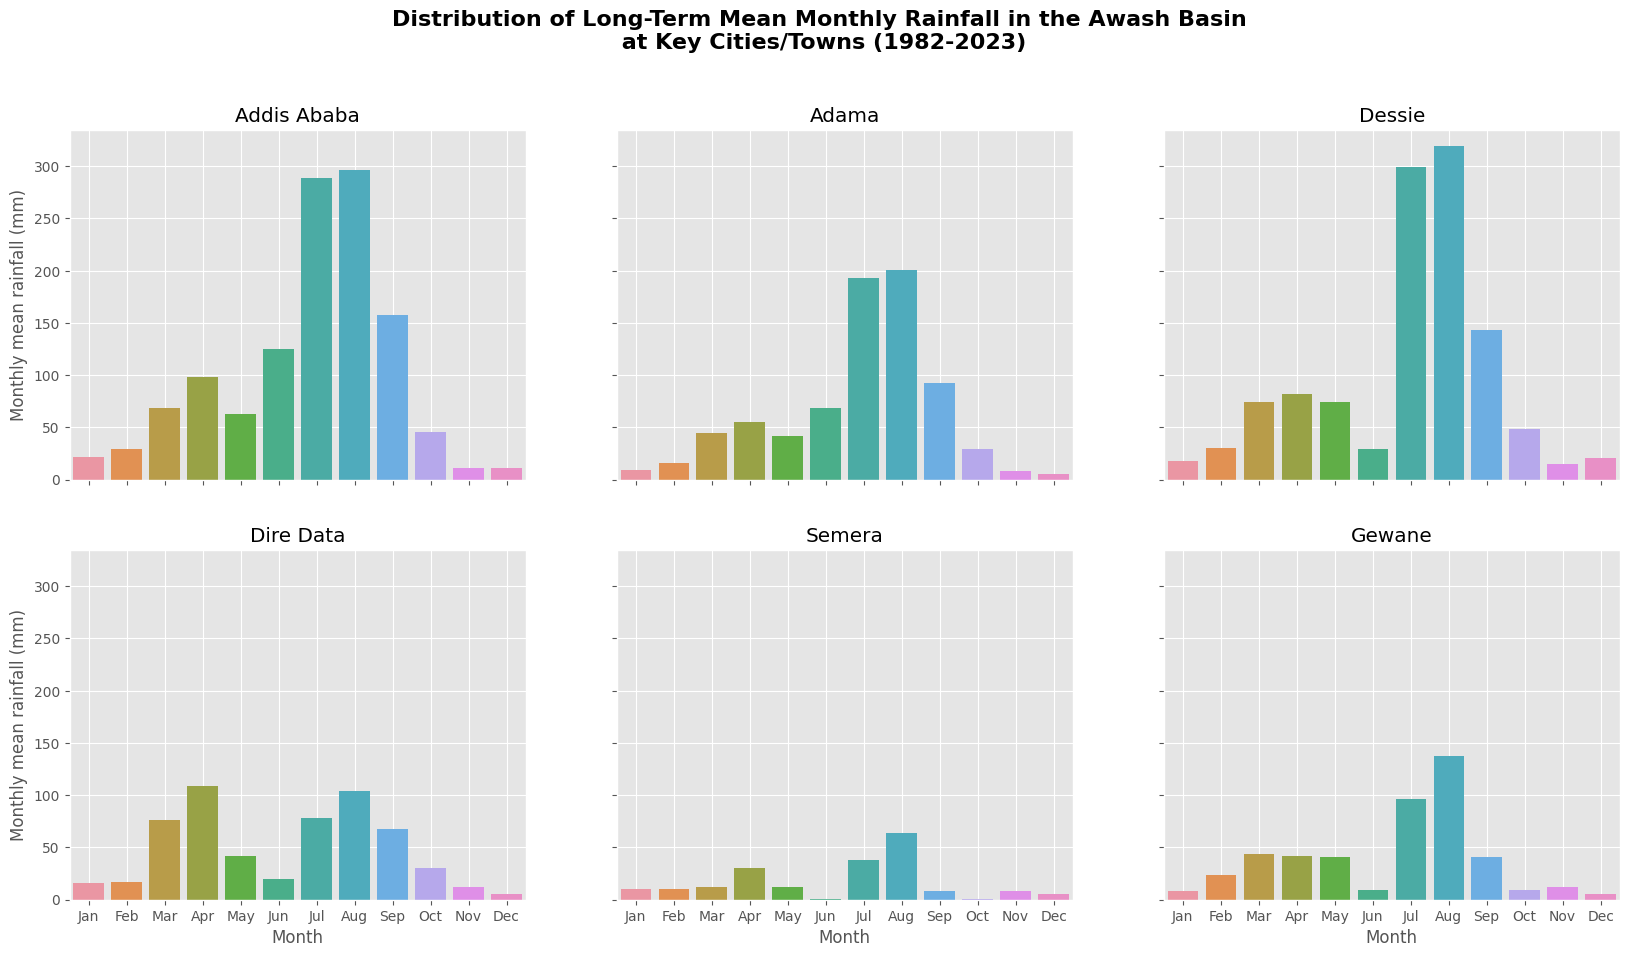

In [14]:
# Create figure and axes objects
fig,axs = plt.subplots(2,3,figsize=(20,10),sharex='all',sharey='all')
# Enumerate city dictionary to get city name 
city = list(enumerate(cities))
for i, ax in enumerate(axs.flat):
    # Get city name
    city_name = city[i][1] 
    # Using city name query monthly data
    df_city = df.query('city==@city_name')
    # Using numeric month value to abriviated month name
    x=[calendar.month_abbr[month] for month in df_city.index]
    # Use seaborn package to plot bar chart
    sns.barplot(df_city,x=x, y='rainfall', ax=ax)
    # Set some chart properties
    ax.set_title(city_name)
    ax.tick_params(axis='both', which='major', labelsize=10)
    if i==0 or i==3:
        ax.set_ylabel('Monthly mean rainfall (mm)')
    else:
        ax.set_ylabel('')
    if i > 2:
        ax.set_xlabel('Month')
    ax.grid(visible=True)
# Add tittle
plt.suptitle(t='Distribution of Long-Term Mean Monthly Rainfall in the Awash Basin\n at Key Cities/Towns (1982-2023)',x=0.5,y=1.0,size=16,weight='bold')
plt.show()

### Extract mean montly rainfall for each sub-catchments
The long-term mean monthly rainfall values can be extracted for each sub-catchments in the Awash Basin using zonal statistics. The code below is used to demonstrate the extraction of the mean rainfall values as pandas DataFrame and save the result to disk in CSV format. Mean annual rainfall can be calculated by either summing monthly rainfall values or applying zonal statistics to annual rainfall gridded data.

#### _Carryout zonal statistics_
To compute zonal statistics, the function requires a zonal dataset (geodataframe), a raster array (e.g., rainfall), its spatial transformation (affine), and specified statistical metrics (mean, min, max). For convenient output, the `geojson_out` parameter can be set to `True`, generating a GeoJSON-formatted result.

In [15]:
# Get transformation values from rainfall data
affine = ds_monthly.rio.transform()
# Select ID and Name columns from aoi geodataframe
df = awash_subcatchments[['ID','Name']]
# Iterate through month dimension and compute
# zonal statistics
for month in ds_monthly.month.data:
    # Select rainfall grid for the month
    da = ds_monthly.rainfall.sel(month=month)
    # Get month abbreviated  name using calendar
    month_name = calendar.month_abbr[month]
    # Compute zonal statistics and get result as GeoJSON
    zonal_stat = zonal_stats(aoi,da.values,affine=affine, stats='mean',geojson_out=True)
    # Select ID and mean fields only
    zonal_stat =gpd.GeoDataFrame.from_features(zonal_stat)[['ID','mean']]
    # Rename mean to month name
    zonal_stat = zonal_stat.rename(columns={'mean':month_name})
    # Uppend result to df
    df = pd.merge(df,zonal_stat, on='ID').round(0)
    
# Compute mean annual value
df['Annual'] = df.loc[:,'Jan':'Dec'].sum(axis=1)  
     

In [16]:
df

,ID,Name,Jan,Feb,Mar,Apr,May,Jun,Jul,Aug,Sep,Oct,Nov,Dec,Annual
0,1,Mille,26.0,28.0,57.0,76.0,55.0,11.0,151.0,191.0,52.0,24.0,19.0,12.0,702.0
1,2,Borkena,22.0,31.0,62.0,93.0,68.0,28.0,208.0,239.0,96.0,31.0,19.0,13.0,910.0
2,3,Kessem,10.0,25.0,54.0,65.0,50.0,56.0,225.0,227.0,88.0,21.0,10.0,6.0,837.0
3,4,Awash - Miesso,12.0,24.0,63.0,84.0,63.0,49.0,155.0,155.0,93.0,38.0,14.0,8.0,758.0
4,5,Awash US of Koka,12.0,29.0,60.0,66.0,76.0,103.0,220.0,216.0,106.0,23.0,7.0,5.0,923.0
5,7,Awash Malka Kunture,14.0,30.0,55.0,73.0,100.0,144.0,246.0,251.0,130.0,22.0,9.0,7.0,1081.0
6,8,Akaki,11.0,27.0,55.0,71.0,81.0,117.0,266.0,280.0,133.0,18.0,7.0,5.0,1071.0
7,9,Mojo,9.0,24.0,51.0,61.0,68.0,95.0,244.0,258.0,109.0,21.0,7.0,5.0,952.0
8,10,Awash - Arba US,15.0,28.0,77.0,105.0,79.0,68.0,181.0,175.0,114.0,56.0,17.0,11.0,926.0
9,11,Keleta - Werenso,20.0,23.0,70.0,86.0,67.0,79.0,159.0,172.0,130.0,64.0,16.0,10.0,896.0


### Save result to disk

In [17]:
df.to_csv('AW_Subcatchments_Rainfall.csv')

### Update Awash Sub-catchments attribute data and plot catchment level mean annual rainfall
Leverage the calculated mean annual rainfall for basin sub-catchments to generate static and interactive attribute maps using GeoPandas. To accomplish this, merge the zonal statistics DataFrame with the sub-catchment GeoDataFrame.

In [18]:
# Drop Name field which is not required
rain_subset = df.drop('Name', axis=1)#[['ID','Jan':'Annual']]
# Join sub-catchment attribute with output zonal statistical table
awash_subcatchments =  awash_subcatchments.merge(rain_subset, on='ID')
# Rename column name 
awash_subcatchments.rename(columns={'Annual': 'Annual rainfall (mm)'}, inplace=True)

#### Static map

Begin by establishing classification ranges according to the mean annual rainfall values. These ranges can be determined based on either local expertise or commonly recognized standards. The classification presented in this context is solely for the purpose of mapping and does not imply specific climatic interpretations.

In [19]:
awash_subcatchments

,ID,Name,Area_km2,geometry,Jan,Feb,Mar,Apr,May,Jun,Jul,Aug,Sep,Oct,Nov,Dec,Annual rainfall (mm)
0,1,Mille,5727.21,"POLYGON ((40.46250 11.66667, 40.46319 11.65501...",26.0,28.0,57.0,76.0,55.0,11.0,151.0,191.0,52.0,24.0,19.0,12.0,702.0
1,2,Borkena,3252.27,"POLYGON ((39.65777 11.06471, 39.65774 11.06474...",22.0,31.0,62.0,93.0,68.0,28.0,208.0,239.0,96.0,31.0,19.0,13.0,910.0
2,3,Kessem,3739.54,"POLYGON ((40.09495 9.22843, 40.09538 9.22675, ...",10.0,25.0,54.0,65.0,50.0,56.0,225.0,227.0,88.0,21.0,10.0,6.0,837.0
3,4,Awash - Miesso,9719.50,"POLYGON ((40.10037 9.22029, 40.10067 9.22076, ...",12.0,24.0,63.0,84.0,63.0,49.0,155.0,155.0,93.0,38.0,14.0,8.0,758.0
4,5,Awash US of Koka,3234.25,"POLYGON ((38.92304 8.90777, 38.92842 8.90360, ...",12.0,29.0,60.0,66.0,76.0,103.0,220.0,216.0,106.0,23.0,7.0,5.0,923.0
5,7,Awash Malka Kunture,4483.07,"POLYGON ((38.65833 8.76250, 38.65591 8.76285, ...",14.0,30.0,55.0,73.0,100.0,144.0,246.0,251.0,130.0,22.0,9.0,7.0,1081.0
6,8,Akaki,1675.06,"POLYGON ((39.06667 9.07083, 39.05612 9.07027, ...",11.0,27.0,55.0,71.0,81.0,117.0,266.0,280.0,133.0,18.0,7.0,5.0,1071.0
7,9,Mojo,1728.16,"POLYGON ((39.25674 8.82138, 39.25677 8.82124, ...",9.0,24.0,51.0,61.0,68.0,95.0,244.0,258.0,109.0,21.0,7.0,5.0,952.0
8,10,Awash - Arba US,1806.96,"POLYGON ((39.72917 8.27083, 39.73271 8.27174, ...",15.0,28.0,77.0,105.0,79.0,68.0,181.0,175.0,114.0,56.0,17.0,11.0,926.0
9,11,Keleta - Werenso,1877.99,"POLYGON ((39.50798 8.38505, 39.50833 8.38750, ...",20.0,23.0,70.0,86.0,67.0,79.0,159.0,172.0,130.0,64.0,16.0,10.0,896.0


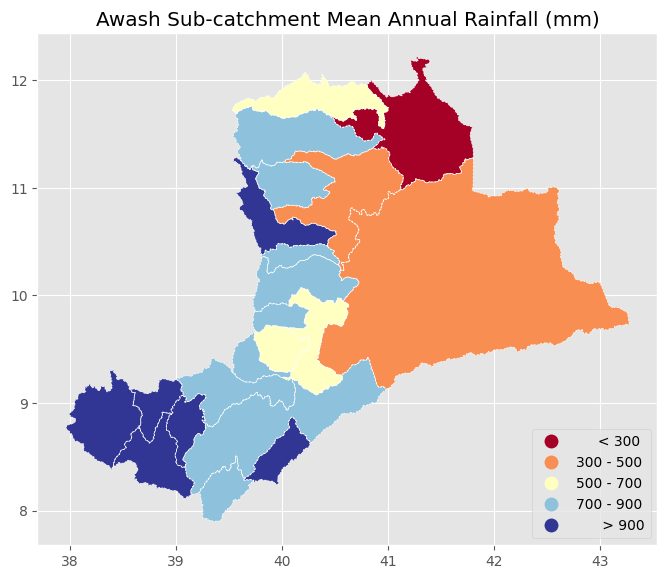

In [20]:
# Set list of bins
bins = [300,500,700,900]
# Legend label classes
class_label = ['     < 300',
'300 - 500',
'500 - 700',
'700 - 900',
'      > 900']
# Create plot space
fig, ax = plt.subplots(figsize=(8,10))
# Plot 
awash_subcatchments.plot(column='Annual rainfall (mm)',
                         cmap='RdYlBu',
                         scheme='user_defined',
                         classification_kwds={'bins': bins},
                         k=8,
                         ax=ax,
                         legend=True,
                        legend_kwds={'fmt': '{:,.0f}',
                                    'loc': 'lower right',
                                    'labels': class_label})
# Add sub-catchment boundary to the plot
awash_subcatchments.boundary.plot(color='white',ax=ax, linewidth=0.5,linestyle='--')
# set title of the plot
plt.title('Awash Sub-catchment Mean Annual Rainfall (mm)')
plt.show()

#### Interactive map
GeoPandas allows for the creation of interactive maps using the explore() method that implements the folium library. Interactive map plotting offers comparable customization options to static map plotting, along with extra functionalities.

In [21]:
# Plot interactive map using inbuilt GeoPandas explore() method
awash_subcatchments.explore('Annual rainfall (mm)',
                    cmap='RdYlBu',
                    popup = True,
                    k=6,
                    scheme='FisherJenks',
                    tiles='OpenStreetMap',
                    style_kwds ={
                            'stroke': True,
                            'color': 'white',
                            'width': 1,
                            'fillOpacity' : 0.7
                            },
                    legend_kwds={
                        'caption': 'Rainfall (mm)',
                        'colorbar': False,
                        'labels': class_label
                    }
                           )

---

## Additional information

**License:** The code in this notebook is licensed under the [Apache License, Version 2.0](https://www.apache.org/licenses/LICENSE-2.0). 
Digital Earth Africa data is licensed under the [Creative Commons by Attribution 4.0](https://creativecommons.org/licenses/by/4.0/) license.

**Contact:** If you need assistance, please post a question on the [Open Data Cube Slack channel](http://slack.opendatacube.org/) or on the [GIS Stack Exchange](https://gis.stackexchange.com/questions/ask?tags=open-data-cube) using the `open-data-cube` tag (you can view previously asked questions [here](https://gis.stackexchange.com/questions/tagged/open-data-cube)).
If you would like to report an issue with this notebook, you can file one on [Github](https://github.com/digitalearthafrica/deafrica-sandbox-notebooks).

**Compatible datacube version:**

In [22]:
print(datacube.__version__)

1.8.15


**Last Tested:**

In [23]:
from datetime import datetime
datetime.today().strftime('%Y-%m-%d')

'2024-08-27'